# Downloading data from kaggle

In [7]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# Extracting the zip file
from zipfile import ZipFile

dataset = '...\Twitter Sentiment Analysis\\sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
    zip.extractall()
    print('The dataset is extracted!')

The dataset is extracted!


# Importing libraries

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report,
roc_curve, roc_auc_score, RocCurveDisplay)

# Loading the data

In [ ]:
file = 'Twitter_data.csv'
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
data = pd.read_csv(file, sep=',', names=column_names, encoding='ISO-8859-1')
df = pd.DataFrame(data)

In [21]:
df.shape

(1600000, 6)

In [22]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [23]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [28]:
df.isna().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [26]:
df.duplicated().sum()

0

In [29]:
df['target'].replace(4, 1, inplace=True)

In [31]:
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

* **0 is negative sentiment**
* **1 is positive sentiment**

# Stemming

In [32]:
ps = PorterStemmer()

In [33]:
def stemming(content):
    
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)

    return stemmed_content

In [36]:
%%time
df['stemmed_content'] = df['text'].apply(stemming)

CPU times: total: 1h 54min 53s
Wall time: 2h 31s


In [37]:
df.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [38]:
#df.to_csv('Twitter_data_stemmed.csv', index=False)

In [39]:
file = 'Twitter_data_stemmed.csv'
data1 = pd.read_csv(file, sep=',')
df1 = pd.DataFrame(data1)

In [40]:
df1.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


# Train Test Split

In [41]:
X = df1['stemmed_content'].values
Y = df1['target'].values

In [42]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [43]:
print(Y)

[0 0 0 ... 1 1 1]


In [44]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=7)

In [45]:
X_train.shape, x_test.shape, Y_train.shape, y_test.shape

((1280000,), (320000,), (1280000,), (320000,))

In [54]:
print(X_train)

['im come back mum friend hous met cute littl boy year old guess'
 'samicappola come get yearbook owe chill oh im leav present' 'tire' ...
 'updat site style' 'jonathanrknight guess'
 'peopl say fond read say found right book']


In [55]:
print(x_test)

['oh forgot import birthday today mrsrestrictor redact year old today'
 'tire yawn best work'
 'wonder time tonight stinkin awesom famili even chelsey bo alright' ...
 'eat sushi' 'hotnsaucey day good friend' 'yay oral final exam']


In [59]:
np.sum(pd.isna(X_train))

402

In [61]:
np.sum(pd.isna(x_test))

93

In [63]:
X_train = np.where(pd.isna(X_train), '', X_train)
x_test = np.where(pd.isna(x_test), '', x_test)

# Vectorization

In [64]:
vectorizer = TfidfVectorizer()

In [65]:
X_train = vectorizer.fit_transform(X_train)
x_test = vectorizer.transform(x_test)

In [66]:
print(X_train)

  (0, 155372)	0.28025612403710826
  (0, 300402)	0.28164691480372833
  (0, 453293)	0.26730987929913863
  (0, 49383)	0.2981972422694594
  (0, 237192)	0.26537306011695083
  (0, 86882)	0.30159464794998875
  (0, 262111)	0.3555114768058745
  (0, 170258)	0.2762802934137004
  (0, 138742)	0.24513704938905198
  (0, 279423)	0.3428184401343486
  (0, 31110)	0.20773704112163793
  (0, 78681)	0.22576199333749816
  (0, 177827)	0.21427584629824487
  (1, 322661)	0.31356968603824703
  (1, 230543)	0.24061578831492064
  (1, 299033)	0.1972545806518825
  (1, 70180)	0.30992185225350954
  (1, 305640)	0.3826922105576465
  (1, 453295)	0.4089354835572553
  (1, 145799)	0.1556199416062376
  (1, 350909)	0.5440254661314423
  (1, 78681)	0.19857578617690264
  (1, 177827)	0.1884727983145768
  (2, 409653)	1.0
  (3, 336514)	0.3435788672894467
  :	:
  (1279994, 375510)	0.24963676833883203
  (1279994, 371210)	0.21239382765987702
  (1279994, 129214)	0.29611126482529604
  (1279994, 290816)	0.1980705533534787
  (1279994, 150667

In [67]:
print(x_test)

  (0, 453293)	0.2147088227361715
  (0, 411033)	0.3190359682563617
  (0, 335523)	0.5019062696098175
  (0, 300402)	0.2262246261280556
  (0, 299033)	0.18013019468696764
  (0, 277123)	0.5498437106140087
  (0, 178709)	0.30763458557423734
  (0, 136191)	0.25595893278772636
  (0, 42799)	0.23259338082271522
  (1, 452765)	0.7131030172984495
  (1, 445317)	0.314363397907563
  (1, 409653)	0.4414973538142055
  (1, 39459)	0.44467946585255413
  (2, 444429)	0.2508912564017652
  (2, 412343)	0.21181427109967296
  (2, 408641)	0.17446103046604197
  (2, 384351)	0.4489961539402112
  (2, 127912)	0.2603631559671138
  (2, 124343)	0.21757689112411835
  (2, 68871)	0.4881406163788745
  (2, 46494)	0.3964047789290299
  (2, 28897)	0.22575268477323093
  (2, 12453)	0.3140750440261823
  (3, 445317)	0.2480083789348721
  (3, 412035)	0.30499991663853565
  :	:
  (319994, 349338)	0.2736536233759103
  (319994, 131790)	0.444678567420096
  (319994, 102965)	0.499039675674248
  (319994, 18696)	0.6916169953040396
  (319995, 459380

# Training the model

In [69]:
model = LogisticRegression(max_iter=1000)

In [70]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [71]:
model_predict_train = model.predict(X_train)
model_predict_test = model.predict(x_test)

In [72]:
train_acc = accuracy_score(Y_train, model_predict_train)
test_acc = accuracy_score(y_test, model_predict_test)

In [104]:
print(train_acc*100)

81.008203125


In [103]:
print(test_acc*100)

77.93875


In [80]:
print(confusion_matrix(y_test, model_predict_test))

[[121484  38516]
 [ 32080 127920]]


In [86]:
print(confusion_matrix(Y_train, model_predict_train))

[[505254 134746]
 [108349 531651]]


In [81]:
print(classification_report(y_test, model_predict_test))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [85]:
print(classification_report(Y_train, model_predict_train))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81    640000
           1       0.80      0.83      0.81    640000

    accuracy                           0.81   1280000
   macro avg       0.81      0.81      0.81   1280000
weighted avg       0.81      0.81      0.81   1280000



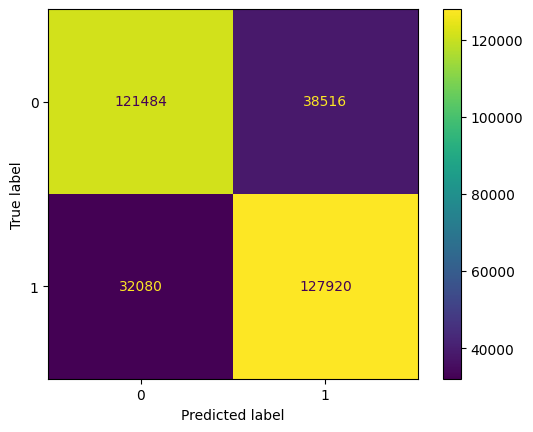

In [87]:
# test data
conf_matrix = confusion_matrix(y_test, model_predict_test)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

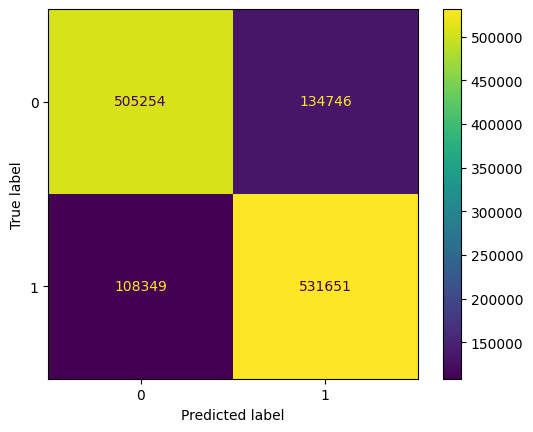

In [88]:
# train data
conf_matrix = confusion_matrix(Y_train, model_predict_train)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

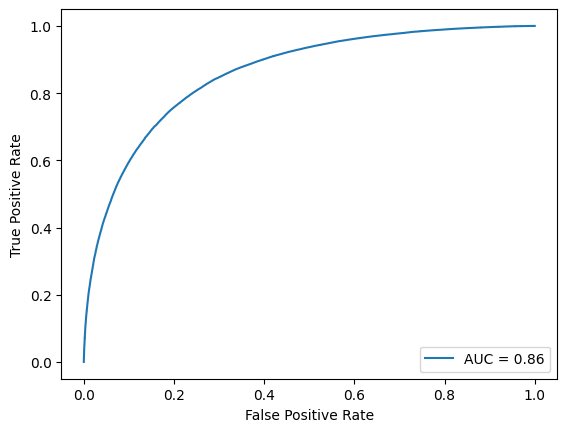

In [94]:
#AUC
score = model.decision_function(x_test)
fpr, tpr, _ = roc_curve(y_test, score, pos_label=model.classes_[1])
auc = roc_auc_score(y_test, score)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc).plot()

In [102]:
input_text ='''Rahul is a bad example of a leader for a country which is the fifth largest economy in the world!
                People dont want to see him as a prime minister because they believe Rahul will be a devastating
                    minister & ruin the country!'''

input_vec = vectorizer.transform([input_text])

input_vec = input_vec.reshape(1, -1)

predict = model.predict(input_vec)

print("Prediction:", predict)

Prediction: [0]
